## TO DO

 
### Spray [ Mikhail ] 

- In looping, stop inspecting observations
    - previous to the first spray (2011)
    - in years we don't have spray data for (sprays only in ?2011? and ?2013?
    - for speed
- Figure out how to calculate direction from two lat/long
- For each (relevant) observation, create dictionary which contains the information for the previous spray (that year only) 
    - dict: For all sprays in previous spray, {SprayID : (Dist, Dir, days)}  


### Weather [ Chrissy /  Claudia]  

- Weather data needs to be calculated for the times **between** observations
- For each year create dictionary {StationID : [ (Date1, Date2)] }
- Given those Date Pairs (Date1, Date2), calculate:
    - High, Low, Mean, StandardDeviation For:
        - Temp
        - Dew Point
        - Pressures
        - ?Heating / Cooling?
    - Total / Mean
        - Wind
        - Precip
- Those means/ totals etc, should then be able to be merged with each mosquito observation
/n
- A dictionary should also be created to correlate with the spray dates that on the SINGLE DATE of a spray what were:
    - sunset
    - wind speed / dir  
    
    

### Parks and Water [ William ]      

- Find shape files for all parks and waterways in chicago  [Done]
- find nearest point of each park/waterway to each trap loc [Done]
- Added Area for each parks from shapefiles [Done]

In [7]:
import pandas as pd
import pickle
import numpy as np

### Initial Data Read and Split

In [97]:
#df = pd.read_csv('./input/train.csv')

#spray = pd.read_csv('./input/spray.csv')

In [9]:
#from sklearn.model_selection import train_test_split

In [10]:
#X_train, X_test, y_train, y_test = train_test_split(df.drop('WnvPresent', axis = 'columns'),
#                                                    df['WnvPresent'], test_size = .25,
#                                                   stratify = df['WnvPresent'],
#                                                    random_state = 1738)

In [11]:
import numpy as np
print(df.WnvPresent.mean())
print(np.mean(y_test))
print(np.mean(y_train))

0.05244622120692937
0.0525314046440807
0.052417819520243686


In [12]:
import pickle

#train = [X_train, y_train]
#test = [X_test, y_test]

'''
with open('trainOrig.pickle', 'wb') as f:
    pickle.dump(train, f, protocol=0)

with open('test.pickle', 'wb') as f:
    pickle.dump(test, f, protocol = 0)
'''

In [31]:
import pickle
data = [df,spray,(weather_st1, weather_st2)]

with open('cleanData.pickle', 'wb') as f:
    pickle.dump(data, f, protocol=0)

### Cleaning Training Data

In [26]:
import pickle
import pandas as pd


with open('trainOrig.pickle', 'rb') as f:
    train = pickle.load(f)

X_train = train[0]
y_train = train[1]
rawdf = pd.concat([X_train, y_train], axis = 'columns')


def buildTrapDict(data):
    tDict = {}
    for l in data.index:
        #print(l)
        trap = data.loc[l,'Trap']
        add = data.loc[l, 'AddressNumberAndStreet']
        lat = data.loc[l, 'Latitude']
        long = data.loc[l, 'Longitude']
        
        if trap not in tDict.keys():
            tDict[trap] = [{'Address':add,
                          'Latitude': lat,
                          'Longitude': long}]
    return tDict

dct = buildTrapDict(rawdf) ## Need to add in T035 and T009

In [94]:
rawdf.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
1379,2007-08-02,"5000 South Union Avenue, Chicago, IL 60609, USA",CULEX RESTUANS,50,S UNION AVE,T082,"5000 S UNION AVE, Chicago, IL",41.803423,-87.642984,8,3,0
2704,2007-08-24,"6600 South Kilpatrick Avenue, Chicago, IL 6062...",CULEX PIPIENS,66,S KILPATRICK AVE,T156,"6600 S KILPATRICK AVE, Chicago, IL",41.772846,-87.740029,9,3,0


In [27]:
def cleanX(xdata):
    toDrop = ['Address','Block','Street', 'AddressNumberAndStreet']
    
    toRet = xdata.copy()
    toRet['Date'] = pd.to_datetime(toRet['Date'])
    
    toRet['Yr'] = [t.year for t in toRet['Date']]
    toRet['Mo'] = [t.month for t in toRet['Date']]
    toRet['Day'] = [t.day for t in toRet['Date']]
    
    toRet['Location'] = [(toRet.loc[idx,'Longitude'], toRet.loc[idx,'Latitude'])
                  for idx in toRet.index]
    
    toRet = toRet.drop(toDrop, axis = 'columns')
    
    #toRet['Yr'] = toRet['Date'].dt.year
    
    return toRet

In [28]:
df = cleanX(rawdf)

In [100]:
df.head(2)

,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Yr,Mo,Day,Location
1379,2007-08-02,CULEX RESTUANS,T082,41.803423,-87.642984,8,3,0,2007,8,2,"(-87.642984, 41.803423)"
2704,2007-08-24,CULEX PIPIENS,T156,41.772846,-87.740029,9,3,0,2007,8,24,"(-87.740029, 41.772846)"


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7879 entries, 1379 to 9570
Data columns (total 11 columns):
Date               7879 non-null datetime64[ns]
Species            7879 non-null object
Trap               7879 non-null object
Latitude           7879 non-null float64
Longitude          7879 non-null float64
AddressAccuracy    7879 non-null int64
NumMosquitos       7879 non-null int64
WnvPresent         7879 non-null int64
Yr                 7879 non-null int64
Mo                 7879 non-null int64
Day                7879 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(6), object(2)
memory usage: 738.7+ KB


### Spray

In [29]:
spray = pd.read_csv('./input/spray.csv')
spray['DT'] = [spray.loc[idx, 'Date']+' '+ spray.loc[idx,'Time']
               if spray.loc[idx,'Time']== str else spray.loc[idx, 'Date']
               for idx in spray.index]
spray['Date'] = pd.to_datetime(spray['DT'])

spray['Yr'] = [t.year for t in spray['Date']]
spray['Mo'] = [t.month for t in spray['Date']]
spray['Day'] = [t.day for t in spray['Date']]
spray['Hour'] =[t.hour + (t.minute/60) for t in spray['Date']]

spray['Location'] = [(spray.loc[idx,'Longitude'], spray.loc[idx,'Latitude'])
                  for idx in spray.index]

spray = spray.drop(['Time', 'DT'], axis = 'columns')

spray.head(3)

,Date,Latitude,Longitude,Yr,Mo,Day,Hour,Location
0,2011-08-29,42.391623,-88.089163,2011,8,29,0.0,"(-88.0891633333, 42.3916233333)"
1,2011-08-29,42.391348,-88.089163,2011,8,29,0.0,"(-88.0891633333, 42.3913483333)"
2,2011-08-29,42.391022,-88.089157,2011,8,29,0.0,"(-88.0891566667, 42.3910216667)"


### Lat/Long Work

#### Parks and Water

Feature Engineering  

- Create areas for each water and park feature
- create (center) for each area

- add interaction term for week of year / feature?

In [52]:
from scipy.spatial import cKDTree
import numpy as np

spray_dict = {}

for i in spray['Date'].dt.date.value_counts().index:
    
    spray_dict[i] = cKDTree( np.array( spray[spray['Date'] >= i ][['Latitude','Longitude']] ) )


In [53]:
import time
# TTT_cKDTree =  tree of TTT data


# TTT_cKDTree.query(array'GGG',k , distance) = 
#            for value in array'GGG" |  with k neighbors | within distance
#
# returns     distance to neighbors, neighbor id within 'TTT'


# eg: LOCATION_A.query(np.array(LOCATION_B.iloc[7117]),k=1)
#       (0.006, 1281)
#  LOCATION_A.iloc[1281] is (0.006) away from LOCATION_B.iloc[7117]


#1 unit of lat|long = 69 miles

sorted_dates = list(spray_dict.keys())
sorted_dates.sort(reverse = True)

from datetime import datetime

#plan is to iterate through all df_locs
#see what the date is
#find the first spray date that is after that df_date
#use the spray tree to find the closest spray

#make a list of 
# [df_locs, dist to last spray, date of last spray]

lastSpray = df[['Date']]
lastSpray['SprayDist'] = None
lastSpray['SprayID'] = None
lastSpray['SprayDate'] = None

firstSpray = sorted_dates[-1]

for idx in df.index:
    if df.loc[idx, 'Date'].date() > firstSpray:
        
        for i, dt in enumerate(sorted_dates):
            if df.loc[idx, 'Date'].date() > dt:
                 
                spray_inst = spray_dict[dt].query(np.array(df.loc[idx,['Latitude','Longitude']]),1)
           
                lastSpray.at[idx,'SprayDist'] = spray_inst[0]
                lastSpray.at[idx,'SprayID'] = spray_inst[1]
                lastSpray.at[idx,'SprayDate'] = dt
                
                break


lastSpray['SprayMiles'] = [d*69 if d != None else None for d in lastSpray['SprayDist']]

#hunt['days since last spray'] = hunt['date of last spray'] - hunt['Date']
#dont hate me for not going to git, i was having trouble with it


C:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

In [54]:
lastSpray.head(30)

,Date,SprayDist,SprayID,SprayDate,SprayMiles
1379,2007-08-02,None,None,None,NaN
2704,2007-08-24,None,None,None,NaN
4742,2009-07-17,None,None,None,NaN
3107,2007-09-12,None,None,None,NaN
2053,2007-08-16,None,None,None,NaN
3789,2007-10-09,None,None,None,NaN
4501,2009-07-06,None,None,None,NaN
7557,2011-08-26,None,None,None,NaN
5520,2009-08-25,None,None,None,NaN
5476,2009-08-25,None,None,None,NaN


### Working with Weather Data

- Date Time Conversion
- Location Data for stations
- conversion of objects into int


In [30]:
weather = pd.read_csv('./input/weather.csv')

#weather info: years: 2007-2014 months: 5,6,7,8,9,10, 1 observation per day per station

#Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
#Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level


#Convert datatypes
weather['Date'] = pd.to_datetime(weather['Date'])

#Drop columns that we are not interested in 
weather = weather.drop({'Depart', 'Depth', 'Water1', 'SnowFall', 'CodeSum', 'Heat', 'Cool'}, axis=1)

#Replace 'M' = missing value with NaN & '  T' with NaN
weather = weather.replace('M', np.nan)
#Replace'  T' with 0.001 
weather = weather.replace('  T', 0.001)
#Replace'  -' with 0000 
weather = weather.replace('-', '0000')

#Convert datatypes
weather['Tavg'] = weather['Tavg'].astype(float)
weather['WetBulb'] = weather['WetBulb'].astype(float)

weather['Sunrise'] = pd.to_datetime(weather['Sunrise'], format="%H%M")
#Fix some data ex: 16:60 --> 1700
weather['Sunset'] = [date if date[-2:] != '60' else str(int(date[0:2])+1)+'00' for date in weather['Sunset']]
weather['Sunset'] = pd.to_datetime(weather['Sunset'], format="%H%M")

weather['PrecipTotal'] = weather['PrecipTotal'].astype(float)
weather['StnPressure'] = weather['StnPressure'].astype(float)
weather['SeaLevel'] = weather['SeaLevel'].astype(float)
weather['ResultSpeed'] = weather['ResultSpeed'].astype(float)
weather['AvgSpeed'] = weather['AvgSpeed'].astype(float)

#Drop null values 
weather.dropna(inplace=True)

#Weather from Station 1 
weather_st1 = weather[weather['Station']== 1]

#Weather from Station 2
weather_st2 = weather[weather['Station']== 2]

In [60]:
weather.head(6)

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,Sunrise,Sunset,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67.0,51,56.0,1900-01-01 04:48:00,1900-01-01 18:49:00,0.0,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68.0,51,57.0,1900-01-01 00:00:00,1900-01-01 00:00:00,0.0,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51.0,42,47.0,1900-01-01 04:47:00,1900-01-01 18:50:00,0.0,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52.0,42,47.0,1900-01-01 00:00:00,1900-01-01 00:00:00,0.0,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56.0,40,48.0,1900-01-01 04:46:00,1900-01-01 18:51:00,0.0,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58.0,40,50.0,1900-01-01 00:00:00,1900-01-01 00:00:00,0.0,29.46,30.12,12.9,6,13.2


In [61]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2918 entries, 0 to 2943
Data columns (total 15 columns):
Station        2918 non-null int64
Date           2918 non-null datetime64[ns]
Tmax           2918 non-null int64
Tmin           2918 non-null int64
Tavg           2918 non-null float64
DewPoint       2918 non-null int64
WetBulb        2918 non-null float64
Sunrise        2918 non-null datetime64[ns]
Sunset         2918 non-null datetime64[ns]
PrecipTotal    2918 non-null float64
StnPressure    2918 non-null float64
SeaLevel       2918 non-null float64
ResultSpeed    2918 non-null float64
ResultDir      2918 non-null int64
AvgSpeed       2918 non-null float64
dtypes: datetime64[ns](3), float64(7), int64(5)
memory usage: 364.8 KB


### Example of bringing in map data

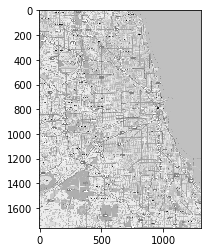

In [37]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
mapdata = np.loadtxt("./input/mapdata_copyright_openstreetmap_contributors.txt")
plt.imshow(mapdata, cmap = plt.get_cmap('gray'))
plt.savefig('map.png')